# Mixture-of-Pathways model.
See "Brain-Like Processing Pathways Form in Models With Heterogeneous Experts"
https://arxiv.org/pdf/2506.02813

Author: Jack Cook Danyal Akarca Rui Ponte Costa, Jascha Achterberg

The code is based on the implementation:
https://anonymous.4open.science/r/mixture-of-pathways-anon-48BA/README.md

# Dependencies


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from dataclasses import dataclass
from typing import List, Optional
import warnings
from itertools import product
import matplotlib.pyplot as plt

# Model configuration


In [2]:
@dataclass
class MoPConfig:
    """Configuration class for the Mixture of Pathways model."""
    input_dim: int = 4
    output_dim: int = 3
    intermediate_dim: int = 64
    # Defines 3 MoE layers, each with 3 experts (0=identity, 16/32=hidden_dim)
    layers: List[str] = ("0,16,32", "0,16,32", "0,16,32")
    task_id: str = "iris"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    task_dim: int = 10
    expert_cost_exponent: float = 2.0
    # Disable complex dropout/noise features for this simple task
    within_expert_dropout_prob: Optional[float] = None
    routing_weight_noise: Optional[float] = None
    dropout_max_prob: Optional[float] = None
    dropout_router_weight_threshold: Optional[float] = None
    flat_expert_knockout_prob: Optional[float] = None


/home/user/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Model


In [3]:
class Expert(nn.Module):
    def __init__(
        self,
        config: MoPConfig,
        hidden_dim: int,
    ):
        super().__init__()
        self.identity = hidden_dim == 0
        if not self.identity:
            self.rnn = nn.GRU(config.intermediate_dim, hidden_dim)
            self.batchnorm = nn.BatchNorm1d(hidden_dim)
            self.relu = nn.ReLU()
            self.dropout = (
                nn.Dropout(config.within_expert_dropout_prob)
                if config.within_expert_dropout_prob is not None
                else nn.Identity()
            )
            self.output_layer = nn.Linear(hidden_dim, config.intermediate_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.identity:
            return x
        else:
            # Reshape for RNN: (batch*seq_len, features) -> (seq_len, batch, features)
            if x.dim() == 2:
                x = x.unsqueeze(0)

            x, _ = self.rnn(x)

            # Reshape back: (seq_len, batch, features) -> (batch*seq_len, features)
            if x.dim() == 3:
                 x = x.squeeze(0)

            if x.shape[0] > 1 and x.var() != 0:
                 x = self.batchnorm(x)

            x = self.relu(x)
            x = self.dropout(x)
            x = self.output_layer(x)
            return x

class CostBasedRouter(nn.Module):
    def __init__(
        self,
        config: MoPConfig,
        expert_dims: List[int],
        num_tasks: int,
    ):
        super(CostBasedRouter, self).__init__()
        self.config = config
        self.expert_dims = expert_dims
        self.num_tasks = num_tasks
        self.rnn = nn.GRU(config.intermediate_dim, config.intermediate_dim)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(config.intermediate_dim, len(expert_dims))

    @torch.autocast(device_type="cuda", dtype=torch.float32)
    def forward(
        self,
        prev_layer_output: torch.Tensor,
        task_ids: torch.Tensor,
        *,
        inference: bool = False,
        inference_dropout_threshold: Optional[float] = None,
        inference_disable_complex_experts: bool = False,
    ):
        logits, _ = self.rnn(prev_layer_output)
        logits = self.relu(logits)
        logits = self.output_layer(logits)
        indices = torch.zeros(
            (logits.shape[0], logits.shape[1], len(self.expert_dims)),
            dtype=torch.long,
            device=logits.device,
        )
        for i in range(len(self.expert_dims)):
            indices[:, :, i] = i
        raw_router_output = F.softmax(logits, dim=-1)
        router_output = raw_router_output.clone()
        # Simplified: Skipping inference and complex dropout logic for this task
        if len(self.expert_dims) > 1:
            routing_costs = torch.tensor(
                [
                    expert_dim**self.config.expert_cost_exponent
                    for expert_dim in self.expert_dims
                ],
                dtype=logits.dtype,
                device=logits.device,
            )
            task_expert_usage_losses = {}
            expert_usage_loss = torch.einsum(
                "ijk,k->ij", raw_router_output, routing_costs
            )
            for i in range(self.num_tasks):
                task_mask = task_ids == i
                if task_mask.sum() > 0:
                    task_expert_usage_losses[i] = (
                        expert_usage_loss[task_mask].sum() / task_mask.sum()
                    )
                else:
                    task_expert_usage_losses[i] = torch.tensor(0.0, device=logits.device)

            expert_entropy_loss = (
                -torch.sum(raw_router_output * torch.log(raw_router_output + 1e-10))
                / raw_router_output.nelement()
            )
        else:
            task_expert_usage_losses = None
            expert_entropy_loss = None
        return (
            raw_router_output,
            router_output,
            indices,
            task_expert_usage_losses,
            expert_entropy_loss,
        )

class SparseMoE(nn.Module):
    def __init__(
        self,
        config: MoPConfig,
        expert_dims: List[int],
        num_tasks: int,
    ):
        super(SparseMoE, self).__init__()
        self.router = CostBasedRouter(config, expert_dims, num_tasks)
        self.experts = nn.ModuleList(
            [Expert(config, expert_dim) for expert_dim in expert_dims]
        )
    def forward(
        self,
        x: torch.Tensor,
        task_ids: torch.Tensor,
        *,
        inference: bool = False,
        inference_dropout_threshold: Optional[float] = None,
        inference_disable_complex_experts: bool = False,
        output_activations: bool = False,
    ):
        (
            raw_router_output,
            router_output,
            indices,
            task_expert_usage_losses,
            expert_entropy_loss,
        ) = self.router(
            x,
            task_ids,
            inference=inference,
        )
        final_output = torch.zeros_like(x)
        flat_x = x.view(-1, x.size(-1))
        flat_router_output = router_output.view(-1, router_output.size(-1))

        for i, expert in enumerate(self.experts):
            expert_mask = (indices == i).any(dim=-1)
            flat_mask = expert_mask.view(-1)
            if not flat_mask.any():
                continue

            expert_input = flat_x[flat_mask]
            expert_output = expert(expert_input)

            gating_scores = flat_router_output[flat_mask, i]
            weighting_output = torch.einsum("i,ij->ij", gating_scores, expert_output)

            # Explicitly cast weighting_output to the same dtype as final_output
            final_output.view(-1, final_output.size(-1)).index_add_(0, torch.where(flat_mask)[0], weighting_output.to(final_output.dtype))

        return (
            final_output,
            raw_router_output,
            task_expert_usage_losses,
            expert_entropy_loss,
        )

class Block(nn.Module):
    def __init__(
        self,
        config: MoPConfig,
        expert_dims: List[int],
        num_tasks: int,
    ):
        super().__init__()
        self.sparse_moe = SparseMoE(config, expert_dims, num_tasks)
        self.ln = nn.LayerNorm(config.intermediate_dim)
    def forward(
        self,
        x: torch.Tensor,
        task_ids: torch.Tensor,
        *,
        inference: bool = False,
        inference_dropout_threshold: Optional[float] = None,
        inference_disable_complex_experts: bool = False,
        output_activations: bool = False,
    ):
        moe_outputs = self.sparse_moe(
            x, task_ids, inference=inference
        )
        # Add post-layer norm (residual connection)
        moe_outputs = (self.ln(x + moe_outputs[0]), *moe_outputs[1:])
        return moe_outputs

class MoPModel(nn.Module):
    def __init__(self, config: MoPConfig):
        super().__init__()
        self.config = config
        # For Iris, we have only 1 "task"
        self.num_tasks = 1 if config.task_id == "iris" else 82
        self.device = torch.device(config.device)
        self.input_layer = nn.Linear(
            self.config.input_dim, self.config.intermediate_dim
        )
        self.blocks = nn.ModuleList(
            [
                Block(
                    self.config,
                    [int(expert_size) for expert_size in layer.split(",")],
                    self.num_tasks,
                )
                for layer in self.config.layers
            ]
        )
        self.output_layer = nn.Linear(
            self.config.intermediate_dim, self.config.output_dim
        )
        self.to(self.config.device)

    @torch.autocast(device_type="cuda", dtype=torch.float16, enabled=True)
    def forward(self, x: torch.Tensor):
        # For Iris (single task), task_ids are all zeros.
        task_ids = torch.zeros(x.shape[0], x.shape[1], dtype=torch.long, device=self.device)
        x = self.input_layer(x)
        total_task_expert_usage_losses = {
            i: torch.tensor(0.0, device=self.device) for i in range(self.num_tasks)
        }
        total_expert_entropy_loss = torch.tensor(0.0, device=self.device)

        for block in self.blocks:
            x, _, task_expert_usage_losses, expert_entropy_loss = block(x, task_ids)
            if task_expert_usage_losses is not None:
                for k in task_expert_usage_losses:
                    total_task_expert_usage_losses[k] = (
                        total_task_expert_usage_losses[k] + task_expert_usage_losses[k]
                    )
            if expert_entropy_loss is not None:
                total_expert_entropy_loss += expert_entropy_loss

        x = self.output_layer(x)
        return x, total_task_expert_usage_losses, total_expert_entropy_loss

/home/user/.local/lib/python3.8/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


# Train and evaluate

--- Configuration ---
Device: cpu
Epochs: 100, Batch Size: 16, Learning Rate: 0.001
Model Layers: ('0,16,32', '0,16,32', '0,16,32')
---------------------

--- Starting Training ---
Epoch [01/100] | Train Loss: 1.2253 | Val Loss: 1.0433 | Aux Usage: 1081.87 | Aux Entropy: 1.0741
Epoch [02/100] | Train Loss: 0.8266 | Val Loss: 0.7676 | Aux Usage: 725.42 | Aux Entropy: 0.9742
Epoch [03/100] | Train Loss: 0.6427 | Val Loss: 0.6215 | Aux Usage: 463.27 | Aux Entropy: 0.8164
Epoch [04/100] | Train Loss: 0.5603 | Val Loss: 0.5387 | Aux Usage: 283.01 | Aux Entropy: 0.6261
Epoch [05/100] | Train Loss: 0.4928 | Val Loss: 0.4828 | Aux Usage: 167.16 | Aux Entropy: 0.4413
Epoch [06/100] | Train Loss: 0.4347 | Val Loss: 0.4397 | Aux Usage: 101.97 | Aux Entropy: 0.3070
Epoch [07/100] | Train Loss: 0.4053 | Val Loss: 0.4051 | Aux Usage: 75.54 | Aux Entropy: 0.2332
Epoch [08/100] | Train Loss: 0.3499 | Val Loss: 0.3789 | Aux Usage: 55.08 | Aux Entropy: 0.1798
Epoch [09/100] | Train Loss: 0.3326 | Val Lo

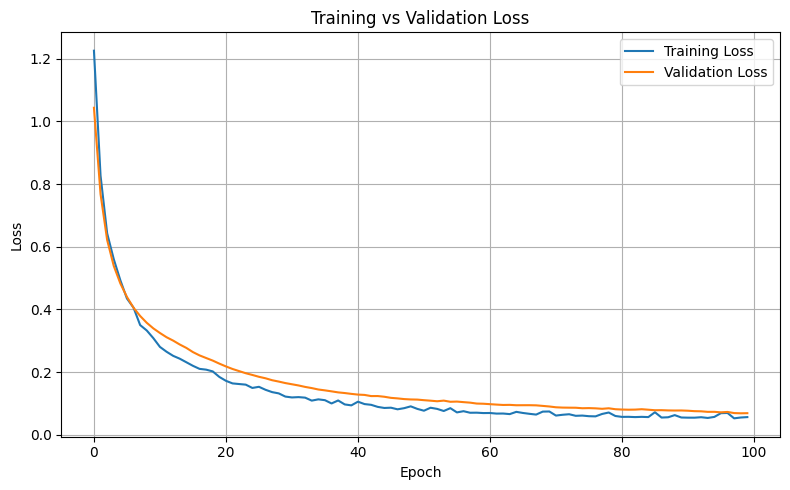

In [4]:
def get_iris_dataloader(batch_size=32, test_size=0.2):
    iris = datasets.load_iris()
    X, y = iris.data, iris.target

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create PyTorch datasets and dataloaders
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader

def run_experiment():
    # Hyperparameters
    config = MoPConfig()
    epochs = 100
    lr = 0.001
    batch_size = 16
    # Coefficients for the auxiliary losses
    usage_loss_coeff = 0.01
    entropy_loss_coeff = 0.001

    print("--- Configuration ---")
    print(f"Device: {config.device}")
    print(f"Epochs: {epochs}, Batch Size: {batch_size}, Learning Rate: {lr}")
    print(f"Model Layers: {config.layers}")
    print("-" * 21)

    # Get data
    train_loader, test_loader = get_iris_dataloader(batch_size)

    # Initialize model, optimizer, and loss function
    model = MoPModel(config)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    classification_criterion = nn.CrossEntropyLoss()
    
    #lists for graphs
    train_losses = []
    val_losses = []

    # --- Training & Validation Loop ---
    print("\n--- Starting Training ---")
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        train_loss, epoch_usage_loss, epoch_entropy_loss = 0.0, 0.0, 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.unsqueeze(1).to(config.device)
            y_batch = y_batch.to(config.device)

            optimizer.zero_grad()
            y_pred, usage_losses, entropy_loss = model(X_batch)
            y_pred = y_pred.squeeze(1)

            class_loss = classification_criterion(y_pred, y_batch)
            total_usage_loss = usage_losses[0] # Single task, so we get the first loss
            total_loss = class_loss + (usage_loss_coeff * total_usage_loss) + (entropy_loss_coeff * entropy_loss)

            total_loss.backward()
            optimizer.step()

            train_loss += class_loss.item()
            epoch_usage_loss += total_usage_loss.item()
            epoch_entropy_loss += entropy_loss.item()

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.unsqueeze(1).to(config.device)
                y_batch = y_batch.to(config.device)

                y_pred, _, _ = model(X_batch)
                y_pred = y_pred.squeeze(1)
                loss = classification_criterion(y_pred, y_batch)
                val_loss += loss.item()

        # --- Print Epoch Results ---
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        avg_usage_loss = epoch_usage_loss / len(train_loader)
        avg_entropy_loss = epoch_entropy_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(
            f"Epoch [{epoch+1:02d}/{epochs:02d}] | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"Aux Usage: {avg_usage_loss:.2f} | "
            f"Aux Entropy: {avg_entropy_loss:.4f}"
        )

    print("--- Training Complete ---")

    # --- Final Accuracy Evaluation ---
    print("\n--- Evaluating Final Accuracy on Test Set ---")
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.unsqueeze(1).to(config.device)
            y_batch = y_batch.to(config.device)

            y_pred, _, _ = model(X_batch)
            y_pred = y_pred.squeeze(1)

            _, predicted_labels = torch.max(y_pred, 1)
            total_samples += y_batch.size(0)
            total_correct += (predicted_labels == y_batch).sum().item()

    accuracy = (total_correct / total_samples) * 100
    print(f"\nFinal Test Accuracy: {accuracy:.2f}%")
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    run_experiment()